# TEMPLATE FOR WORKFLOW


# UPDATED MODELING - PARTIALLY USING FUNCTIONS

## MODEL 1 - 08/06/19

#### NOTE ON PARAMETERS TO CHANGE:
- PARAMETERS TO CHANGE ARE LOCATED WITHIN HASHTAG COMMENTED BANNER SECTIONS
    - Header = `######## Name of section to be edited #######`
    - Footer = `#############################################`
    <br><br>
- **For `ji.def_data_params`:**
    - `num_test_days` = number of days left for test dataset
    - `num_train_days` = number of days prior to test_days to use as training dataset
    - `days_for_x_window` = number of days that should be analyzed together (binned for predictions)
    
    
- **For `ji.make_train_test_series_gens`:**
    - `n_features` = number of features/cols to use (for first model, =1, for second model =# of columns)
    - `batch_size` = 1 -  recommendation for timeseries predictions
    
    
- **For `_def_callbacks_and_params_`:**
    - `loss_function` for model checkpoints
    - `patience` = # of epochs without change before early stopping
    - `min_delta` = threshold for change to be considered significant (and therefore counts as new result)
    <br><br>
    
- **For `_def_callbacks_and_params_`:**
    - `loss` = Loss function for training
    -  `metrics` = Metrics to track during fit (['acc','mae'],)
    - `optimizer`= Optimizer to use during compiling ('optimizers.Nadam())

In [17]:
## IMPORT PACKAGES
from bs_ds.imports import *
import functions_combined_BEST as ji
import my_keras_functions as jik

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload

# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

# Reload modules in case files have been updated
reload(jik)
reload(ji)

Reloading my_keras_functions...
Reloading functions_combined_BEST...


<module 'functions_combined_BEST' from 'D:\\Users\\James\\Dropbox (Personal)\\CODING\\_FLATIRON\\Mod5_FinalProject\\dsc-5-capstone-project-online-ds-ft-021119\\functions_combined_BEST.py'>

In [8]:
# Load stock_df data from functions detailed above
stock_df = ji.load_processed_stock_data()
stock_df.head()

>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>


,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,...,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,
2016-12-29 15:30:00,12/29/2016,15:30,96.25,96.27,96.24,96.27,96.26,96.28,96.25,96.28,...,96.277007,96.573856,96.730494,0.156639,1.002051,98.281110,94.272904,96.263988,89.27,2016-12-29 15:30:00
2016-12-30 09:30:00,12/30/2016,09:30,96.32,96.39,96.32,96.38,96.48,96.48,96.39,96.42,...,96.293537,96.571218,96.721997,0.150779,0.980655,98.254848,94.332227,96.341329,89.38,2016-12-30 09:30:00
2016-12-30 10:30:00,12/30/2016,10:30,96.18,96.21,96.17,96.21,96.19,96.21,96.18,96.21,...,96.307891,96.566317,96.709593,0.143275,0.959724,98.227340,94.388442,96.253776,89.21,2016-12-30 10:30:00
2016-12-30 11:30:00,12/30/2016,11:30,96.29,96.34,96.29,96.34,96.30,96.35,96.30,96.35,...,96.322653,96.563255,96.700645,0.137390,0.938272,98.199196,94.446110,96.311259,89.34,2016-12-30 11:30:00
2016-12-30 12:30:00,12/30/2016,12:30,96.25,96.25,96.25,96.25,96.26,96.26,96.26,96.26,...,96.336531,96.559027,96.689742,0.130715,0.912397,98.161325,94.511736,96.270420,89.25,2016-12-30 12:30:00


In [9]:
################# USER PARAMETERS: Define data parameters for train_test_split  ##############
model_params={}
model_params['data_params'] = ji.def_data_params(stock_df,
                                                 num_test_days=5, num_train_days=365, 
                                                 days_for_x_window=1, verbose=0)
###############################################################################################


###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
dp = model_params['data_params']
df_train, df_test = ji.train_test_split_by_last_days(stock_df,
                                                     periods_per_day = dp['periods_per_day'], 
                                                     num_test_days   =  dp['num_test_days'],
                                                     num_train_days  =  dp['num_train_days'],
                                                     verbose=0, iplot=False)

display(df_train.head(2).style.set_caption('df_train - pre-scaling'))
# ji.display_dict_dropdown(model_params)

###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                transform=True,
                                                                model_params=model_params,
                                                                verbose=2)

df_test = ji.transform_cols_from_library(df_test,col_list=None,col_scaler_dict=scaler_library,
                                                      scaler_library=scaler_library,inverse=False)

# Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data - scaled'))#,
#         df_test.head(2).round(3).style.set_caption('test data'))



################# USER PARAMETERS: Define n_Features and batch sizes for generators  ##############
# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens( df_train['price'], df_test['price'],
                                   n_features=1,batch_size=1, model_params=model_params,
                                   verbose=0)
ji.display_dict_dropdown(model_params)
###############################################################################################

# # ji.display_dict_dropdown(model_params)
# funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
#                   'def_compile_params_optimizer','make_model1'] 
# ihelp_menu(funcs_make_model)

,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,date_time_index.1,filled_timebin,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-22 09:30:00,01/22/2018,09:30,114.34,114.34,114.34,114.34,114.5,114.5,114.5,114.5,2018-01-22 09:30:00,False,114.34,113.986,112.042,111.798,113.236,1.43854,1.55789,115.158,108.927,114.382,107.34,2018-01-22 09:30:00
2018-01-22 10:30:00,01/22/2018,10:30,115.06,115.06,115.03,115.03,115.07,115.07,115.04,115.04,2018-01-22 10:30:00,False,115.03,114.029,112.075,111.833,113.278,1.44542,1.56858,115.212,108.938,114.814,108.03,2018-01-22 10:30:00


These columns were excluded due to incompatible dtypes.
['Date', 'Time', 'date_time_index.1', 'filled_timebin', 'date_time_index']



,Date,Time,BidOpen,BidHigh,BidLow,BidClose,AskOpen,AskHigh,AskLow,AskClose,date_time_index.1,filled_timebin,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,date_time_index
date_time_index,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-22 09:30:00,01/22/2018,09:30,0.876,0.876,0.877,0.877,0.882,0.881,0.882,0.882,2018-01-22 09:30:00,False,0.877,0.878,0.763,0.75,0.828,0.94,0.254,0.669,0.738,0.878,0.877,2018-01-22 09:30:00
2018-01-22 10:30:00,01/22/2018,10:30,0.907,0.907,0.906,0.906,0.906,0.906,0.906,0.906,2018-01-22 10:30:00,False,0.906,0.88,0.765,0.752,0.831,0.942,0.256,0.673,0.738,0.896,0.906,2018-01-22 10:30:00


Using TensorFlow backend.


------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [10]:
def _def_callbacks_and_params_(model_params=None,loss_function='mae',checkpoint_mode='min',filepath=None,
                             stop_mode='min',patience=1,min_delta=.001,verbose=1):
    import functions_combined_BEST as ji
    

            ########## Define loss function and callback params ##########
    callback_params ={}
    callback_params['custom_loss_function'] = loss_function
    callback_params['ModelCheckpoint'] = {'monitor': loss_function, 'mode':checkpoint_mode}
    callback_params['EarlyStopping'] = {'monitor':loss_function, 'mode':stop_mode, 
                                        'patience':patience, 'min_delta':min_delta}

    # CREATING CALLBACKS
    from keras import callbacks

    if filepath is None:
        filepath = f"models/checkpoints/model1_weights_{ji.auto_filename_time(prefix=None)}.hdf5"

    if 'my_rmse' in loss_function:
        import functions_combined_BEST as ji
        loss_function = ji.my_rmse
#         my_rmse=my_rmse
#         loss_function = my_rmse

    # Create ModelCheckPoint
    fun_params=callback_params['ModelCheckpoint']
    checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor=loss_function, mode=fun_params['mode'],
                                           save_best_only=True, verbose=verbose)
    # Create EarlyStopping
    fun_params=callback_params['EarlyStopping']
    early_stop = callbacks.EarlyStopping(monitor=loss_function, mode=fun_params['mode'], patience=fun_params['patience'],
                                         min_delta=fun_params['min_delta'],verbose=verbose)
    callbacks = [checkpoint,early_stop]

    if model_params is None:
        model_params=callback_params
    else:
        model_params['callbacks'] = callback_params
    return callbacks, model_params

################# USER PARAMS: Create ModelCheckpoint and early Stopping callbacks ###################
callbacks, model_params = \
    _def_callbacks_and_params_(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.001, verbose=1)
######################################################################################################


def _def_compile_params_optimizer_(loss='my_rmse',metrics=['acc','my_rmse'],optimizer='optimizers.Nadam()',model_params=None):
    ####### Specify additional model parameters
    from keras import optimizers
         
    compile_params={}
    compile_params['loss']= loss#{'my_rmse':my_rmse}
    compile_params['metrics'] = metrics#['acc',my_rmse]
    
    if type(optimizer) is str:
        optimizer_name = optimizer
        optimizer = eval(optimizer_name)
    else:
        optimizer_name = optimizer.__class__().__str__()
        
    compile_params['optimizer'] = optimizer
    compile_params['optimizer_name'] = optimizer_name#'optimizers.Nadam()'

    if model_params is not None:
        model_params['compile_params'] = compile_params
    else:
        model_params=compile_params
    
    return model_params


################## Add compiler parameters to model_params ############################
model_params = _def_compile_params_optimizer_(
    loss='my_rmse', 
    metrics=['acc','mae'],
    optimizer='optimizers.Nadam()', 
    model_params=model_params)
########################################################################################
ji.display_dict_dropdown(model_params)

Instructions for updating:
Colocations handled automatically by placer.
------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [11]:
# Create keras model from model_params
def _make_model1_(model_params, summary=True):
    from keras.models import Sequential
    from keras.layers import Bidirectional, Dense, LSTM, Dropout
    from IPython.display import display
    from keras.regularizers import l2

    # Specifying input shape (size of samples, rank of samples?)
    n_input = model_params['input_params']['n_input']
    n_features = model_params['input_params']['n_features']
    print(f'input shape: ({n_input},{n_features}')
    input_shape=(n_input, n_features)
    
    # Create model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape =input_shape,return_sequences=True))#,  kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))

    # load compile params and compile
    comp_params = model_params['compile_params']
    # metrics = comp_params['metrics']
    loss=comp_params['loss']
    metrics=comp_params['metrics']
    
    if 'my_rmse' in loss or 'my_rmse' in metrics:

        def check_loss_metrics_for_my_rmse(loss,metrics):
            metric_function = metrics
            loss_function = loss
            
            import functions_combined_BEST as ji
            for i,idx in enumerate(metrics):
                if 'my_rmse' in metrics[i]:
                    metric_function[i]=ji.my_rmse
            
            if 'my_rmse' in loss:
                loss_function=ji.my_rmse
                
            return loss_function, metric_function
        
        loss_function,metric_function = check_loss_metrics_for_my_rmse(loss,metrics)
        
    model.compile(loss=loss_function, metrics=metric_function,
                  optimizer=comp_params['optimizer'])##eval(comp_params['optimizer']), metrics=metrics)#optimizer=optimizers.Nadam()
    

    if summary is True:
        display(model.summary())
        
#     if return_params:
#         model_params['compile_params']['loss'] = loss_str
#         model_params['compile_params']['metrics'] = metrics_str
#         return model, model_params
    return model
#########################################################################################

model1=_make_model1_(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

input shape: (7,1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


None

------------ Parameters for Keras Model ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------ 

--- CLOCK STARTED @:    08/06/19 - 01:44:14 PM           Label:            --- 
Instructions for updating:
Use tf.cast instead.
Epoch 1/4
 - 32s - loss: 0.0444 - acc: 0.0012 - mean_absolute_error: 0.0444
Epoch 2/4
 - 30s - loss: 0.0283 - acc: 0.0012 - mean_absolute_error: 0.0283
Epoch 3/4
 - 31s - loss: 0.0246 - acc: 0.0012 - mean_absolute_error: 0.0246
Epoch 4/4
 - 31s - loss: 0.0220 - acc: 0.0012 - mean_absolute_error: 0.0220
--- TOTAL DURATION   =  2 min, 6.289 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,08/06/19 - 01:44:14 PM,"2 min, 6.289 sec",




------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------


,Training Data,Test Data
acc,0.001177,0.000000
loss,0.014549,0.011091
mean_absolute_error,0.014549,0.011091


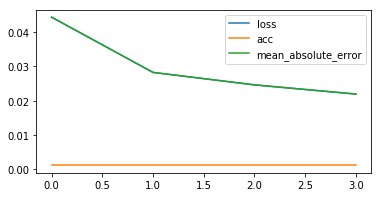

In [12]:
def _fit_model_(model,train_generator,model_params=None,epochs=None,callbacks=None,verbose=2,workers=3):
    import bs_ds as bs
    import functions_combined_BEST as ji
    from IPython.display import display

    quiet_command = ji.quiet_mode(True,True,True)
    exec(quiet_command)
    
    if model_params is None:
        model_params={}
    model_params['fit_params'] = {'epochs':epochs}#,'callbacks':callbacks}

    # Instantiating clock timer
    clock = bs.Clock()

    print('---'*20)
    print('\tFITTING MODEL:')
    print('---'*20,'\n')     
    
    # start the timer
    clock.tic('')

    # Fit the model
    fit_params = model_params['fit_params']
    if callbacks is None:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'], 
                                       verbose=2, use_multiprocessing=True, workers=3)
    else:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'],
                                       callbacks=callbacks,
                                       verbose=2,use_multiprocessing=True, workers=3)
    # model_results = model.history.history
    clock.toc('')
    
    return model,model_params,history
#########################################################################################
# Fit keras model to train_generator

model1,model_params,history =_fit_model_(model1,train_generator,
                                          model_params=model_params,
                                          epochs=4,callbacks=callbacks)

# Get results from model.evaluate_generator()
eval_results = ji.evaluate_model_plot_history(model1, train_generator, test_generator)

In [13]:
### PREFER NEW WAY - GET DF_MODEL FIRST THEN GET EVALUATE_REGRESSION INFORMATION?
## Get true vs pred data as a dataframe and iplot
df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
                                  true_train_series = df_train['price'],
                                  true_test_series = df_test['price'],
                                  model_params=model_params,
                                  preds_from_gen=True, 
                                  preds_from_train_preds=True, 
                                  preds_from_test_preds=True,
                                 inverse_tf=True,iplot=True)

# Get evaluation metrics
regr_evals = ji.get_evaluate_regression_dict(df_model1,metrics=['r2', 'mae', 'U'],
                                             show_results_df=True, return_as_df=True)


# Compare predictions if predictions timebins shifted
df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'], df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),
                                   display_results=True, display_U_info=False,
                                   return_shifted_df=True, return_results=True)

28 28 28
Removed i_.
Using all columns...


,R²,MAE,U
Prediction Source,,,
from_gen,0.608,0.256,1.321
from_test_preds,-12.649,2.104,7.732
from_train_preds,-6.748,1.936,8.447


,R²,RMSE,U
Pred Shifted,,,
-4,0.584,0.364,0.95
-3,0.762,0.288,0.793
-2,0.904,0.186,0.604
-1,0.864,0.226,0.753
0,0.608,0.388,1.321
1,0.14,0.508,1.736
2,-0.406,0.591,2.468
3,-0.404,0.599,2.543


,U
# of Bins Shifted,
-4,0.949575
-3,0.793315
-2,0.603571
-1,0.753335
0,1.32073
1,1.73641
2,2.46761
3,2.54346


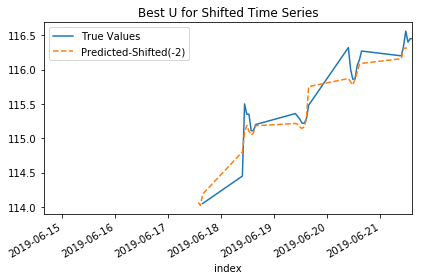

In [14]:
#? ## GET SHIFTED RESULTS FOR PREDS FROM GENERATOR
df_shifted = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                        shift_list=np.arange(-4,4,1),
                        plot_all=False, plot_best=True,
                        color_coded=True,return_results=False,
                                     return_shifted_df=True)

,U
# of Bins Shifted,
-4,7.7632
-3,7.95222
-2,8.13129
-1,8.34628
0,8.55464
1,8.43717
2,8.31965
3,8.20209


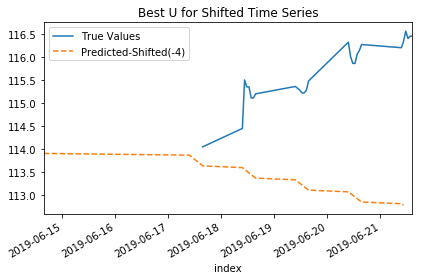

In [15]:
#? ## GET SHIFTED RESULTS FOR PREDS FROM TRAIN PREDS
df_shifted2 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_train_preds'],
                        shift_list=np.arange(-4,4,1),
                        plot_all=False, plot_best=True,
                        color_coded=True,return_results=False,
                                     return_shifted_df=True)
# res_df = ji.compare_time_shifted_model(df_model1,)

In [18]:
ji.save_model_weights_params(model1,model_params=model_params,
                             filename_prefix='models/model1', auto_increment_name=True,
                             auto_filename_suffix=True, suffix_time_format='%m-%d-%y_%I%M%p',
                             save_model_layer_config_xlsx=True)

Model saved as models/model1_08-06-19_0153pm.json
Weights saved as models/model1_08-06-19_0153pm.json_weights.h5


('models/model1_08-06-19_0153pm',
 'models/model1_08-06-19_0153pm.json_weights.h5')

## MODEL 2 - 08/06/19


In [1]:
## IMPORT PACKAGES
from bs_ds.imports import *
import functions_combined_BEST as ji
import my_keras_functions as jik

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload

# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

# Reload modules in case files have been updated
reload(jik)
reload(ji)

## check for stock_df
try: stock_df
except NameError:
    stock_df= None
    
if stock_df is None:
    stock_df = ji.load_processed_stock_data()
    
## check for df_train 
try: df_train
except NameError:
    df_train = None
try: df_test
except NameError:
    df_test = None
    
if df_train is None or df_test is None:
    use_prior_train_test_data = False
    print('Training or test data not found')
else:
    use_prior_train_test_data =  True

bs_ds  v0.8.9 loaded.  Read the docs: https://bs-ds.readthedocs.io/en/latest/index.html
For convenient loading of standard modules use: from bs_ds.imports import *



Package,Handle,Description
bs_ds,bs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


Reloading my_keras_functions...
Reloading functions_combined_BEST...
>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>
Training or test data not found


In [ ]:
use_prior_train_test_data=False
if use_prior_train_test_data == False:
    print('Making new df_train and df_test')
    ################# USER PARAMETERS: Define data parameters for train_test_split  ##############
    model_params={}
    model_params['data_params'] = ji.def_data_params(stock_df.drop('filled_timebin',axis=1),
                                                     num_test_days=10, num_train_days=365, 
                                                     days_for_x_window=1, verbose=0)
    ###############################################################################################


    ###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
    dp = model_params['data_params']
    df_train, df_test = ji.train_test_split_by_last_days(stock_df.drop('filled_timebin',axis=1),
                                                         periods_per_day = dp['periods_per_day'], 
                                                         num_test_days   =  dp['num_test_days'],
                                                         num_train_days  =  dp['num_train_days'],
                                                         verbose=0, iplot=False)

    display(df_train.head(2).style.set_caption('df_train - pre-scaling'))
    # ji.display_dict_dropdown(model_params)

    ###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
    scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                    transform=True,
                                                                    model_params=model_params,
                                                                    verbose=2)

    df_test = ji.transform_cols_from_library(df_test,col_list=None,col_scaler_dict=scaler_library,
                                                          scaler_library=scaler_library,inverse=False)

    # Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data - scaled'))#,
    #         df_test.head(2).round(3).style.set_caption('test data'))



################# USER PARAMETERS: Define n_Features and batch sizes for generators  ##############
# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens(train_data_series=df_train, test_data_series=df_test,y_cols='price',
                                   n_features=len(df_train.columns),batch_size=1, model_params=model_params,
                                   verbose=0)
ji.display_dict_dropdown(model_params)

train_generator[0][0].shape

In [ ]:
###############################################################################################

# # ji.display_dict_dropdown(model_params)
# funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
#                   'def_compile_params_optimizer','make_model1'] 
# ihelp_menu(funcs_make_model)

def _def_callbacks_and_params_(model_params=None,loss_function='mae',checkpoint_mode='min',filepath=None,
                             stop_mode='min',patience=1,min_delta=.005,verbose=1):
    import functions_combined_BEST as ji
    

            ########## Define loss function and callback params ##########
    callback_params ={}
    callback_params['custom_loss_function'] = loss_function
    callback_params['ModelCheckpoint'] = {'monitor': loss_function, 'mode':checkpoint_mode}
    callback_params['EarlyStopping'] = {'monitor':loss_function, 'mode':stop_mode, 
                                        'patience':patience, 'min_delta':min_delta}

    # CREATING CALLBACKS
    from keras import callbacks

    if filepath is None:
        filepath = f"models/checkpoints/model1_weights_{ji.auto_filename_time(prefix=None)}.hdf5"

    if 'my_rmse' in loss_function:
        import functions_combined_BEST as ji
        loss_function = ji.my_rmse
#         my_rmse=my_rmse
#         loss_function = my_rmse

    # Create ModelCheckPoint
    fun_params=callback_params['ModelCheckpoint']
    checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor=loss_function, mode=fun_params['mode'],
                                           save_best_only=True, verbose=verbose)
    # Create EarlyStopping
    fun_params=callback_params['EarlyStopping']
    early_stop = callbacks.EarlyStopping(monitor=loss_function, mode=fun_params['mode'], patience=fun_params['patience'],
                                         min_delta=fun_params['min_delta'],verbose=verbose)
    callbacks = [checkpoint,early_stop]

    if model_params is None:
        model_params=callback_params
    else:
        model_params['callbacks'] = callback_params
    return callbacks, model_params

################# USER PARAMS: Create ModelCheckpoint and early Stopping callbacks ###################
callbacks, model_params = \
    _def_callbacks_and_params_(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.005, verbose=1)
######################################################################################################


def _def_compile_params_optimizer_(loss='my_rmse',metrics=['acc','my_rmse'],optimizer='optimizers.Nadam()',model_params=None):
    ####### Specify additional model parameters
    from keras import optimizers
         
    compile_params={}
    compile_params['loss']= loss#{'my_rmse':my_rmse}
    compile_params['metrics'] = metrics#['acc',my_rmse]
    
    if type(optimizer) is str:
        optimizer_name = optimizer
        optimizer = eval(optimizer_name)
    else:
        optimizer_name = optimizer.__class__().__str__()
        
    compile_params['optimizer'] = optimizer
    compile_params['optimizer_name'] = optimizer_name#'optimizers.Nadam()'

    if model_params is not None:
        model_params['compile_params'] = compile_params
    else:
        model_params=compile_params
    
    return model_params


################## Add compiler parameters to model_params ############################
model_params = _def_compile_params_optimizer_(
    loss='my_rmse', 
    metrics=['acc','mae'],
    optimizer='optimizers.Nadam()', 
    model_params=model_params)
########################################################################################
ji.display_dict_dropdown(model_params)

# Create keras model from model_params
def _make_model2_(model_params, summary=True):
    from keras.models import Sequential
    from keras.layers import Bidirectional, Dense, LSTM, Dropout
    from IPython.display import display
    from keras.regularizers import l2

    # Specifying input shape (size of samples, rank of samples?)
    n_input = model_params['input_params']['n_input']
    n_features = model_params['input_params']['n_features']
    print(f'input shape: ({n_input},{n_features}')
    input_shape=(n_input, n_features)
    
    # Create model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape =input_shape,return_sequences=True))#,  kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))

    # load compile params and compile
    comp_params = model_params['compile_params']
    # metrics = comp_params['metrics']
    loss=comp_params['loss']
    metrics=comp_params['metrics']
    
    if 'my_rmse' in loss or 'my_rmse' in metrics:

        def check_loss_metrics_for_my_rmse(loss,metrics):
            metric_function = metrics
            loss_function = loss
            
            import functions_combined_BEST as ji
            for i,idx in enumerate(metrics):
                if 'my_rmse' in metrics[i]:
                    metric_function[i]=ji.my_rmse
            
            if 'my_rmse' in loss:
                loss_function=ji.my_rmse
                
            return loss_function, metric_function
        
        loss_function,metric_function = check_loss_metrics_for_my_rmse(loss,metrics)
        
    model.compile(loss=loss_function, metrics=metric_function,
                  optimizer=comp_params['optimizer'])##eval(comp_params['optimizer']), metrics=metrics)#optimizer=optimizers.Nadam()
    

    if summary is True:
        display(model.summary())
        
#     if return_params:
#         model_params['compile_params']['loss'] = loss_str
#         model_params['compile_params']['metrics'] = metrics_str
#         return model, model_params
    return model
#########################################################################################

model2=_make_model1_(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

In [ ]:
def _fit_model_(model,train_generator,model_params=None,epochs=None,callbacks=None,verbose=2,workers=3):
    import bs_ds as bs
    import functions_combined_BEST as ji
    from IPython.display import display

    quiet_command = ji.quiet_mode(True,True,True)
    exec(quiet_command)
    
    if model_params is None:
        model_params={}
    model_params['fit_params'] = {'epochs':epochs}#,'callbacks':callbacks}

    # Instantiating clock timer
    clock = bs.Clock()

    print('---'*20)
    print('\tFITTING MODEL:')
    print('---'*20,'\n')     
    
    # start the timer
    clock.tic('')

    # Fit the model
    fit_params = model_params['fit_params']
    if callbacks is None:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'], 
                                       verbose=2, use_multiprocessing=True, workers=3)
    else:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'],
                                       callbacks=callbacks,
                                       verbose=2,use_multiprocessing=True, workers=3)
    # model_results = model.history.history
    clock.toc('')
    
    return model,model_params,history


#########################################################################################
# Fit keras model to train_generator

model2,model_params,history =_fit_model_(model2,train_generator,
                                          model_params=model_params,
                                          epochs=8,callbacks=callbacks)

# Get results from model.evaluate_generator()
eval_results = ji.evaluate_model_plot_history(model2, train_generator, test_generator)


#########################################################################################
#########################################################################################

# ji.reload([jik,ji])
### PREFER NEW WAY - GET DF_MODEL FIRST THEN GET EVALUATE_REGRESSION INFORMATION?
## Get true vs pred data as a dataframe and iplot
df_model2 = ji.get_model_preds_df(model2, test_generator=test_generator,
                                  true_train_series = df_train['price'],
                                  true_test_series = df_test['price'],
                                  model_params=model_params,
                                  preds_from_gen=True, 
                                  preds_from_train_preds=False, 
                                  preds_from_test_preds=False,
                                  inverse_tf=True,iplot=True)

# Get evaluation metrics
regr_evals = ji.get_evaluate_regression_dict(df_model2,metrics=['r2', 'mae', 'U'],
                                             show_results_df=True, return_as_df=True)


# Compare predictions if predictions timebins shifted
df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model2['true_from_gen'], df_model2['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),
                                   display_results=True, display_U_info=False,
                                   return_shifted_df=True, return_results=True)

In [ ]:
# #ji.save_model_weights_params(model2,model_params=model_params,
#                              filename_prefix='models/best_stock/model2_BEST', auto_increment_name=True,
#                              auto_filename_suffix=True, suffix_time_format='%m-%d-%y_%I%M%p',
#                              save_model_layer_config_xlsx=True)

### TESTING LOADING

In [ ]:
model_filename = "models/best_stock/model2_BEST_08-06-19_0604pm"
ji.load_model_weights_params()
pd.read_excel()

## Model 1


In [158]:
## IMPORT PACKAGES
from bs_ds.imports import *

import functions_combined_BEST as ji
import my_keras_functions as jik

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload


# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

# Reload modules in case files have been updated
reload(jik)
reload(ji)

# Suppress warnings
ji.quiet_mode()

"import warnings\nwarnings.filterwarnings('ignore')\nimport os\nos.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'"

In [2]:
# Load stock_df data from functions detailed above

"""NOTE: current processed filename ready for modeling is: processed_datafile"""
processed_datafile = '_stock_df_with_technical_indicators.csv'

# LOAD IN FULL STOCK DATASET 
full_df = ji.load_processed_stock_data()

# SELECT DESIRED COLUMNS
stock_df = full_df[[
    'price','ma7','ma21','26ema','12ema','MACD',
    '20sd','upper_band','lower_band','ema','momentum','filled_timebin'
]].copy()

# print(stock_df.index.freq)
display(stock_df.head(3))
fig = ji.plotly_time_series(stock_df['price'])

>> File found. Loading _stock_df_with_technical_indicators.csv
DatetimeIndex(['2016-12-29 15:30:00', '2019-06-21 15:30:00'], dtype='datetime64[ns]', name='date_time_index', freq=None) <CustomBusinessHour: CBH=09:30-16:30>


,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2016-12-29 15:30:00,96.27,96.864898,96.277007,96.573856,96.730494,0.156639,1.002051,98.281110,94.272904,96.263988,89.27,False
2016-12-30 09:30:00,96.38,96.850204,96.293537,96.571218,96.721997,0.150779,0.980655,98.254848,94.332227,96.341329,89.38,False
2016-12-30 10:30:00,96.21,96.831633,96.307891,96.566317,96.709593,0.143275,0.959724,98.227340,94.388442,96.253776,89.21,False


In [3]:
## Define data parameters for train_test_split 
model_params={}
model_params['data_params'] = ji.def_data_params(stock_df,
                                                 num_test_days=5, num_train_days=365, 
                                                 days_for_x_window=1, verbose=0)

###### TRAIN TEST SPLIT BY NUMBER OF DAYS ######
dp = model_params['data_params']
df_train, df_test = ji.train_test_split_by_last_days(stock_df,
                                                     periods_per_day = dp['periods_per_day'], 
                                                     num_test_days   =  dp['num_test_days'],
                                                     num_train_days  =  dp['num_train_days'],
                                                     verbose=0, iplot=False)

display(df_train.head(2).style.set_caption('df_train - pre-scaling'))
# ji.display_dict_dropdown(model_params)

###### RESCALE DATA USING MinMaxScalers FIT ON TRAINING DATA's COLUMNS ######
scaler_library, df_train, model_params = ji.make_scaler_library(df_train, 
                                                                transform=True,
                                                                model_params=model_params,
                                                                verbose=2)

df_test = ji.transform_cols_from_library(df_test,col_list=None,col_scaler_dict=scaler_library,
                                                      scaler_library=scaler_library,inverse=False)

# Show transformed dataset
display( df_train.head(2).round(3).style.set_caption('training data - scaled'))#,
#         df_test.head(2).round(3).style.set_caption('test data'))

# Create timeseries generators
train_generator, test_generator, model_params =\
    ji.make_train_test_series_gens( df_train['price'], df_test['price'],
                                   n_features=1,batch_size=1, model_params=model_params,
                                   verbose=0)

ji.display_dict_dropdown(model_params)

# # ji.display_dict_dropdown(model_params)
# funcs_make_model = ['make_train_test_series_gens','def_callbacks_and_params',
#                   'def_compile_params_optimizer','make_model1'] 
# ihelp_menu(funcs_make_model)

,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2018-01-22 09:30:00,114.34,113.986,112.042,111.798,113.236,1.43854,1.55789,115.158,108.927,114.382,107.34,False
2018-01-22 10:30:00,115.03,114.029,112.075,111.833,113.278,1.44542,1.56858,115.212,108.938,114.814,108.03,False


These columns were excluded due to incompatible dtypes.
['filled_timebin']



,price,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,filled_timebin
date_time_index,,,,,,,,,,,,
2018-01-22 09:30:00,0.877,0.878,0.763,0.75,0.828,0.94,0.254,0.669,0.738,0.878,0.877,False
2018-01-22 10:30:00,0.906,0.88,0.765,0.752,0.831,0.942,0.256,0.673,0.738,0.896,0.906,False


Using TensorFlow backend.


------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [4]:
def _def_callbacks_and_params_(model_params=None,loss_function='mae',checkpoint_mode='min',filepath=None,
                             stop_mode='min',patience=1,min_delta=.001,verbose=1):
    import functions_combined_BEST as ji
    

            ########## Define loss function and callback params ##########
    callback_params ={}
    callback_params['custom_loss_function'] = loss_function
    callback_params['ModelCheckpoint'] = {'monitor': loss_function, 'mode':checkpoint_mode}
    callback_params['EarlyStopping'] = {'monitor':loss_function, 'mode':stop_mode, 
                                        'patience':patience, 'min_delta':min_delta}

    # CREATING CALLBACKS
    from keras import callbacks

    if filepath is None:
        filepath = f"models/checkpoints/model1_weights_{ji.auto_filename_time(prefix=None)}.hdf5"

    if 'my_rmse' in loss_function:
        import functions_combined_BEST as ji
        loss_function = ji.my_rmse
#         my_rmse=my_rmse
#         loss_function = my_rmse

    # Create ModelCheckPoint
    fun_params=callback_params['ModelCheckpoint']
    checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor=loss_function, mode=fun_params['mode'],
                                           save_best_only=True, verbose=verbose)
    # Create EarlyStopping
    fun_params=callback_params['EarlyStopping']
    early_stop = callbacks.EarlyStopping(monitor=loss_function, mode=fun_params['mode'], patience=fun_params['patience'],
                                         min_delta=fun_params['min_delta'],verbose=verbose)
    callbacks = [checkpoint,early_stop]

    if model_params is None:
        model_params=callback_params
    else:
        model_params['callbacks'] = callback_params
    return callbacks, model_params
#########################################################################################
# Create ModelCheckpoint and early Stopping callbacks
callbacks, model_params = \
    _def_callbacks_and_params_(model_params, loss_function='my_rmse',
                               checkpoint_mode='min', stop_mode = 'min',
                                patience=1, min_delta=0.001, verbose=1)

#########################################################################################
def _def_compile_params_optimizer_(loss='my_rmse',metrics=['acc','my_rmse'],optimizer='optimizers.Nadam()',model_params=None):
    ####### Specify additional model parameters
    from keras import optimizers
         
    compile_params={}
    compile_params['loss']= loss#{'my_rmse':my_rmse}
    compile_params['metrics'] = metrics#['acc',my_rmse]
    
    if type(optimizer) is str:
        optimizer_name = optimizer
        optimizer = eval(optimizer_name)
    else:
        optimizer_name = optimizer.__class__().__str__()
        
    compile_params['optimizer'] = optimizer
    compile_params['optimizer_name'] = optimizer_name#'optimizers.Nadam()'

    if model_params is not None:
        model_params['compile_params'] = compile_params
    else:
        model_params=compile_params
    
    return model_params
#########################################################################################
# Add compiler parameters to model_params for func make_model1(model_params)
model_params = _def_compile_params_optimizer_(
    loss='my_rmse', metrics=['acc','mae'],
    optimizer='optimizers.Nadam()', model_params=model_params)

ji.display_dict_dropdown(model_params)

Instructions for updating:
Colocations handled automatically by placer.
------------ Dictionary Contents ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

In [5]:
# Create keras model from model_params
def _make_model1_(model_params, summary=True):
    from keras.models import Sequential
    from keras.layers import Bidirectional, Dense, LSTM, Dropout
    from IPython.display import display
    from keras.regularizers import l2

    # Specifying input shape (size of samples, rank of samples?)
    n_input = model_params['input_params']['n_input']
    n_features = model_params['input_params']['n_features']
    print(f'input shape: ({n_input},{n_features}')
    input_shape=(n_input, n_features)
    
    # Create model architecture
    model = Sequential()
    model.add(LSTM(units=50, input_shape =input_shape,return_sequences=True))#,  kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01),
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, activation='relu'))
    model.add(Dense(1))

    # load compile params and compile
    comp_params = model_params['compile_params']
    # metrics = comp_params['metrics']
    loss=comp_params['loss']
    metrics=comp_params['metrics']
    
    if 'my_rmse' in loss or 'my_rmse' in metrics:

        def check_loss_metrics_for_my_rmse(loss,metrics):
            metric_function = metrics
            loss_function = loss
            
            import functions_combined_BEST as ji
            for i,idx in enumerate(metrics):
                if 'my_rmse' in metrics[i]:
                    metric_function[i]=ji.my_rmse
            
            if 'my_rmse' in loss:
                loss_function=ji.my_rmse
                
            return loss_function, metric_function
        
        loss_function,metric_function = check_loss_metrics_for_my_rmse(loss,metrics)
        
    model.compile(loss=loss_function, metrics=metric_function,
                  optimizer=comp_params['optimizer'])##eval(comp_params['optimizer']), metrics=metrics)#optimizer=optimizers.Nadam()
    

    if summary is True:
        display(model.summary())
        
#     if return_params:
#         model_params['compile_params']['loss'] = loss_str
#         model_params['compile_params']['metrics'] = metrics_str
#         return model, model_params
    return model
#########################################################################################

model1=_make_model1_(model_params)

# Display all parameters used to create model
ji.display_dict_dropdown(model_params,title='Parameters for Keras Model')

input shape: (7,1
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 7, 50)             10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


None

------------ Parameters for Keras Model ------------


interactive(children=(Dropdown(description='dict_to_display', options={'data_params': {'num_test_days': 5, 'nu…

------------------------------------------------------------
	FITTING MODEL:
------------------------------------------------------------ 

--- CLOCK STARTED @:    08/05/19 - 06:15:05 PM           Label:            --- 
Epoch 1/2
 - 37s - loss: 0.0150 - acc: 0.0012 - mean_absolute_error: 0.0150
Epoch 2/2
 - 37s - loss: 0.0151 - acc: 0.0012 - mean_absolute_error: 0.0151
--- TOTAL DURATION   =  1 min, 13.690 sec --- 


Lap #,Start Time,Duration,Label
TOTAL,08/05/19 - 06:15:05 PM,"1 min, 13.690 sec",




------------------------------------------------------------------------------------
	EVALUATE MODEL:
------------------------------------------------------------------------------------


,Training Data,Test Data
acc,0.001177,0.00000
loss,0.025584,0.04055
mean_absolute_error,0.025584,0.04055


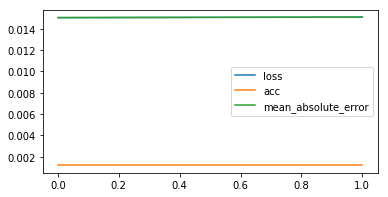

28 28 28
Removed i_.
Using all columns...


In [347]:
def _fit_model_(model,train_generator,model_params=None,epochs=2,callbacks=None,verbose=2,workers=3):
    import bs_ds as bs
    import functions_combined_BEST as ji
    from IPython.display import display

    quiet_command = ji.quiet_mode(True,True,True)
    exec(quiet_command)
    
    if model_params is None:
        model_params={}
    model_params['fit_params'] = {'epochs':epochs}#,'callbacks':callbacks}

    # Instantiating clock timer
    clock = bs.Clock()

    print('---'*20)
    print('\tFITTING MODEL:')
    print('---'*20,'\n')     
    
    # start the timer
    clock.tic('')

    # Fit the model
    fit_params = model_params['fit_params']
    if callbacks is None:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'], 
                                       verbose=2, use_multiprocessing=True, workers=3)
    else:
        
        history = model.fit_generator(train_generator,epochs=fit_params['epochs'],
                                       callbacks=callbacks,
                                       verbose=2,use_multiprocessing=True, workers=3)
    # model_results = model.history.history
    clock.toc('')
    
    return model,model_params,history
#########################################################################################
# Fit keras model to train_generator

model1,model_params,history =_fit_model_(model1,train_generator,
                                          model_params=model_params,
                                          epochs=2,callbacks=callbacks)

# Get results from model.evaluate_generator()
eval_results = ji.evaluate_model_plot_history(model1, train_generator, test_generator)


### PREFER NEW WAY - GET DF_MODEL FIRST THEN GET EVALUATE_REGRESSION INFORMATION?
# # # Get true vs pred data as a dataframe
# df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
#                                   true_train_series = df_train['price'],
#                                   true_test_series = df_test['price'],model_params=model_params,
#                                   preds_from_gen=True, preds_from_train_preds=True, preds_from_test_preds=True,
#                                  inverse_tf=True,iplot=False)
# # Get true vs pred data as a dataframe
df_model1 = ji.get_model_preds_df(model1, test_generator=test_generator,
                                  true_train_series = df_train['price'],
                                  true_test_series = df_test['price'],model_params=model_params,
                                  preds_from_gen=True, preds_from_train_preds=True, preds_from_test_preds=False,
                                 inverse_tf=True,iplot=False)

regr_evals = ji.get_evaluate_regression_dict(df_model1,show_results_df=True,return_as_df=True)

df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),display_results=True,
                                   display_U_info=False, return_shifted_df=True, return_results=True)

In [355]:
# reload(jik)
# reload(ji)
# ji.plot_best_shift(df_model1, df_results, true_colname='true_from_gen',pred_colname='pred_from_gen')

In [346]:
df_results, df_shifted =\
ji.compare_eval_metrics_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
                                   shift_list=np.arange(-4,4,1),
                                   return_shifted_df=True,
                                   return_results=True,display_U_info=False, display_results=True)

,R²,RMSE,U
Pred Shifted,,,
-4,0.573,0.369,1.067
-3,0.637,0.355,1.005
-2,0.694,0.332,1.082
-1,0.733,0.316,1.045
0,0.448,0.461,1.564
1,-0.17,0.593,2.018
2,-0.895,0.686,2.922
3,-0.949,0.706,3.046


In [356]:
# print('Predictions from Generator\n','---'*20)
# df_res1, df_shifted1 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_gen'],
#                         shift_list=np.arange(-4,4,1),
#                         plot_all=False, plot_best=True,
#                         color_coded=True,return_results=True,
#                                      return_shifted_df=True)

# print('Predictions from Training Data Predictions\n','---'*20)

# df_res2, df_shifted2 = jik.compare_u_for_shifts(df_model1['true_from_gen'],df_model1['pred_from_train_preds'],
#                         shift_list=np.arange(-4,4,1),
#                         plot_all=False, plot_best=True,
#                         color_coded=True,return_results=True,
#                                      return_shifted_df=True)
# # res_df = ji.compare_time_shifted_model(df_model1,)

# EARLIER MODELING

In [ ]:
from functions_combined_BEST import *

# TWITTER DATA: Word2Vec Embeddings + Keras

In [1]:

# Import my custom functions 
import functions_combined_BEST as ji
import my_keras_functions as jik
import function_widgets as fw
import bs_ds as bs

# Import some functions directly
from functions_combined_BEST import ihelp, ihelp_menu, reload

## IMPORT STANDARD PACKAGES
from bs_ds.imports import *
from pprint import pprint


# Import plotly and cufflinks for iplots
import plotly
import cufflinks as cf
cf.go_offline()

bs.big_pandas()
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Reload modules in case files have been updated
reload(jik)
reload(ji)

ihelp(load_twitter_df)

------------------------------------------------------------------------------------
------ HELP ------------------------------------------------------------------------

Help on function load_twitter_df in module functions_combined_BEST:

load_twitter_df(overwrite=True, set_index='time_index', verbose=2, replace_na='')

------------------------------------------------------------------------------------
------ SOURCE ----------------------------------------------------------------------


```python
def load_twitter_df(overwrite=True,set_index='time_index',verbose=2,replace_na=''):
    import pandas as pd
    from IPython.display import display
    try: twitter_df
    except NameError: twitter_df = None
    if twitter_df is not None:
        print('twitter_df already exists.')
        if overwrite==True:
            print('Overwrite=True. deleting original...')
            del(twitter_df)
            
    if twitter_df is None:
        print('loading twitter_df')
        
        twitter_df = pd.read_csv('data/trump_twitter_archive_df.csv', encoding='utf-8', parse_dates=True)
        twitter_df.drop('Unnamed: 0',axis=1,inplace=True)

        twitter_df['date']  = pd.to_datetime(twitter_df['date'])
        twitter_df['time_index'] = twitter_df['date'].copy()
        twitter_df.set_index(set_index,inplace=True,drop=True)


        # Fill in missing values before merging with stock data
        twitter_df.fillna(replace_na, inplace=True)
        twitter_df.sort_index(ascending=True, inplace=True)

        # RECASTING A COUPLE COLUMNS
        twitter_df['is_retweet'] = twitter_df['is_retweet'].astype('bool')
        twitter_df['id_str'] = twitter_df['id_str'].astype('str')
        twitter_df['sentiment_class'] = twitter_df['sentiment_class'].astype('category')

#         twitter_df.reset_index(inplace=True)
        # Check header and daterange of index
    if verbose>0:
        display(twitter_df.head(2))
        print(twitter_df.index[[0,-1]])
    return twitter_df

```

bs_ds  v0.8.9 loaded.  Read the docs: https://bs-ds.readthedocs.io/en/latest/index.html
For convenient loading of standard modules use: from bs_ds.imports import *



Package,Handle,Description
bs_ds,bs,Custom data science bootcamp student package
matplotlib,mpl,Matplotlib's base OOP module with formatting artists
matplotlib.pyplot,plt,Matplotlib's matlab-like plotting module
numpy,np,scientific computing with Python
pandas,pd,High performance data structures and tools
seaborn,sns,High-level data visualization library based on matplotlib


display.max_columns=None
display.expand_frame_repr=False
display.max_rows=None
display.max_info_columns=500
display.precision=4
Reloading my_keras_functions...
Reloading functions_combined_BEST...


<module 'functions_combined_BEST' from 'D:\\Users\\James\\Dropbox (Personal)\\CODING\\_FLATIRON\\Mod5_FinalProject\\dsc-5-capstone-project-online-ds-ft-021119\\functions_combined_BEST.py'>

In [ ]:
skip=True
if skip==False:
    def get_B_day_time_index_shift(test_df, verbose=1):

        fmtYMD= '%Y-%m-%d'

        test_df['day']= test_df['date'].dt.strftime('%Y-%m-%d')
        test_df['time'] = test_df['date'].dt.strftime('%T')
        test_df['dayofweek'] = test_df['date'].dt.day_name()

        test_df_to_period = test_df[['date','content']]
        test_df_to_period = test_df_to_period.to_period('B')
        test_df_to_period['B_periods'] = test_df_to_period.index.values
        test_df_to_period['B_day'] = test_df_to_period['B_periods'].apply(lambda x: x.strftime(fmtYMD))



        test_df['B_day'] = test_df_to_period['B_day'].values
        test_df['B_shifted']=np.where(test_df['day']== test_df['B_day'],False,True)
        test_df['B_time'] = np.where(test_df['B_shifted'] == True,'09:30:00', test_df['time'])

        test_df['B_dt_index'] = pd.to_datetime(test_df['B_day'] + ' ' + test_df['B_time']) 

        test_df['time_shift'] = test_df['B_dt_index']-test_df['date'] 

        if verbose > 0:
            test_df.head(20)

        return test_df

    def reorder_twitter_df_columns(twitter_df, order=[]):
        if len(order)==0:
            order=['date','dayofweek','B_dt_index','source','content','content_raw','retweet_count','favorite_count','sentiment_scores','time_shift']
        twitter_df_out = twitter_df[order]
        twitter_df_out.index = twitter_df.index
        return twitter_df_out


    def match_stock_price_to_tweets(tweet_timestamp,time_after_tweet= 30,time_freq ='T',stock_price=[]):#stock_price_index=stock_date_data):

        import pandas as pd
        from datetime import datetime as dt
        # output={'pre_tweet_price': price_at_tweet,'post_tweet_price':price_after_tweet,'delta_price':delta_price, 'delta_time':delta_time}
        output={}
        # convert tweet timestamp to minute accuracy
        ts=[]
        ts = pd.to_datetime(tweet_timestamp).round(time_freq)

        BH = pd.tseries.offsets.BusinessHour(start='09:30',end='16:30')
        BD = pd.tseries.offsets.BusinessDay()


        # checking if time is within stock_date_data
    #     def roll_B_day_forward(ts):

        if ts not in stock_price.index:
            ts = BH.rollforward(ts)        

            if ts not in stock_price.index:
                return np.nan#"ts2_not_in_index"

        # Get price at tweet time
        price_at_tweet = stock_price.loc[ts]

        if np.isnan(price_at_tweet):
            output['pre_tweet_price'] = np.nan
        else: 
            output['pre_tweet_price'] = price_at_tweet


        # Use timedelta to get desired timepoint following tweet
        hour_freqs = 'BH','H','CBH'
        day_freqs = 'B','D'

        if time_freq=='T':
            ofst=pd.offsets.Minute(time_after_tweet)

        elif time_freq in hour_freqs:
            ofst=pd.offsets.Hour(time_after_tweet)

        elif time_freq in day_freqs:
            ofst=pd.offsets.Day(time_after_tweet)


        # get timestamp to check post-tweet price
        post_tweet_ts = ofst(ts)


        if post_tweet_ts not in stock_price.index:
    #         post_tweet_ts =BD.rollforward(post_tweet_ts)
            post_tweet_ts = BH.rollforward(post_tweet_ts)

            if post_tweet_ts not in stock_price.index:
                return np.nan


        # Get next available stock price
        price_after_tweet = stock_price.loc[post_tweet_ts]
        if np.isnan(price_after_tweet):
            output['post_tweet_price'] = 'NaN in stock_price'
        else:
            # calculate change in price
            delta_price = price_after_tweet - price_at_tweet
            delta_time = post_tweet_ts - ts
            output['post_tweet_price'] = price_after_tweet
            output['delta_time'] = delta_time
            output['delta_price'] = delta_price

    #         output={'pre_tweet_price': price_at_tweet,'post_tweet_price':price_after_tweet,'delta_price':delta_price, 'delta_time':delta_time}

        return output
    
    def unpack_match_stocks(stock_dict):
        stock_series = pd.Series(stock_dict)
        return stock_series

In [2]:
### LOAD IN AND PROCESS TWITTER DATA
reload([jik,ji])
twitter_df, stock_price = ji.load_twitter_df_stock_price()

Reloading my_keras_functions...
Reloading functions_combined_BEST...
loading stock_price
Loading twitter_df


,source,content,date,retweet_count,favorite_count,is_retweet,id_str,has_RT,starts_RT,content_starts_RT,clean_content,content_min_clean,content_hashtags,hashtag_strings,content_mentions,mention_strings,clean_content_stop,clean_content_stop_tokens,case_ratio,sentiment_scores,compound_score,sentiment_class,neg,neu,pos
date,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-20 12:31:53,Twitter for Android,It all begins today! I will see you at 11:00 A...,2017-01-20 12:31:53,70523,268372,False,822421390125043713,False,False,[],It all begins today! I will see you at 11:00 A...,It all begins today! I will see you at 11:00 A...,[],,[],,begins today see swearing movement continues w...,"[begins, today, see, swearing, movement, conti...",0.3304,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.000,1.000,0.000
2017-01-20 17:51:25,Twitter for iPhone,Today we are not merely transferring power fro...,2017-01-20 17:51:25,20125,109640,False,822501803615014918,False,False,[],Today we are not merely transferring power fro...,Today we are not merely transferring power fro...,[],,[],,today merely transferring power one administra...,"[today, merely, transferring, power, one, admi...",0.0148,"{'neg': 0.0, 'neu': 0.919, 'pos': 0.081, 'comp...",0.2144,pos,0.000,0.919,0.081
2017-01-20 17:51:58,Twitter for iPhone,power from Washington D.C. and giving it back ...,2017-01-20 17:51:58,18362,91143,False,822501939267141634,False,False,[],power from Washington D.C. and giving it back ...,power from Washington D.C. and giving it back ...,[#InaugurationDay],#InaugurationDay,[],,power washington c giving back american people,"[power, washington, c, giving, back, american,...",0.0778,"{'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'comp...",0.3400,pos,0.000,0.844,0.156
2017-01-20 17:52:45,Twitter for iPhone,What truly matters is not which party controls...,2017-01-20 17:52:45,42790,180394,False,822502135233384448,False,False,[],What truly matters is not which party controls...,What truly matters is not which party controls...,[],,[],,truly matters party controls government whethe...,"[truly, matters, party, controls, government, ...",0.0086,"{'neg': 0.079, 'neu': 0.776, 'pos': 0.145, 'co...",0.0954,pos,0.079,0.776,0.145
2017-01-20 17:53:17,Twitter for iPhone,January 20th 2017 will be remembered as the da...,2017-01-20 17:53:17,60604,218555,False,822502270503972872,False,False,[],January 20th 2017 will be remembered as the da...,January 20th 2017 will be remembered as the da...,[],,[],,january th remembered day people became rulers...,"[january, th, remembered, day, people, became,...",0.0102,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0.000,1.000,0.000


2017-01-20 09:30:00 2019-06-21 16:00:00
2017-01-20 12:31:53 2019-06-20 00:12:31


In [ ]:
clock = bs.Clock()
clock.tic()
stock_price = ji.get
## LOAD IN RAW TWITTER FILE, PROCESS NLP
twitter_df= ji.load_raw_twitter_file()
twitter_df = ji.full_twitter_df_processing(twitter_df,
                                           cleaned_tweet_col='clean_content')

display(twitter_df.head(3))
print(twitter_df.index[[0,-1]],twitter_df.index.freq)
# twitter_df_backup = twitter_df.copy()
# clock.toc()

## LOAD IN STOCK PRICE DATA
twitter_df = twitter_df.loc[stock_price.index[0]:stock_price.index[-1]];


## AM I SURE I WANT TO GET THE PRICE NOW?
twitter_df = ji.get_stock_prices_for_twitter_data(twitter_df,stock_price['price'])

display(twitter_df.head(3))
clock.toc()
# ji.plotly_time_series(stock_price)

In [ ]:
df_tokenize=df_twitter
df_tokenize['delta_price_class'].value_counts()['pos']

In [ ]:
# dealing with class imbalance by sub-sampling

df_sampled = df_tokenize.loc[df_tokenize['delta_price_class'] =='pos'].sample(n=class_counts['neg'])
df_sampled = pd.concat([df_sampled,df_tokenize.loc[df_tokenize['delta_price_class'] =='neg']], axis=0)
display(df_sampled.head())
display(df_sampled.tail())

In [ ]:
# CREATING TEXT DICT FOR FREQUENCY DISTRIBUTIONS
from nltk import regexp_tokenize
column = 'clean_content_stop'
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

tweets_combined = df_sampled[column]
tweets_combined = ' '.join(tweets_combined)
tweets_tokenized = regexp_tokenize(tweets_combined, pattern)

TEXT = dict()
TEXT['tokens'] = tweets_tokenized
TEXT['text'] = tweets_combined

from nltk import FreqDist
freq_tweets = FreqDist(TEXT['tokens'])#df_sampled['clean_content_stop'])
with plt.style.context('seaborn-notebook'):
    freq_tweets.plot(25)

In [ ]:
df_sampled['delta_time'].loc[df_sampled['delta_time']<'1 day']

In [ ]:
# text_data = df_tokenize['content_min_clean']
# text_data = df_tokenize['content']
text_data = df_sampled['content_min_clean'].apply(lambda x: regexp_tokenize(x, pattern))


from gensim.models import Word2Vec
vector_size = 300

wv_keras = Word2Vec(text_data, size=vector_size, window=, min_count=2, workers=3)
wv_keras.train(text_data,total_examples=wv_keras.corpus_count, epochs=10)

wv = wv_keras.wv
vocab_size = len(wv_keras.wv.vocab)
print(f'There are {vocab_size} words in the word2vec vocabulary, with a vector size {vector_size}.')

In [ ]:
# save the vectors in a new matrix
word_model = wv_keras
vector_size = word_model.wv.vectors[1].shape[0]

embedding_matrix = np.zeros((len(word_model.wv.vocab) + 1, vector_size))
for i, vec in enumerate(word_model.wv.vectors):
  embedding_matrix[i] = vec
embedding_matrix.shape

In [ ]:
# import pickle
# filename = 'word2vec_model_twitter.pickle'

# with open(filename, 'wb') as f:
#     pickle.dump([word_model,vector_size,embedding_matrix],f)

In [ ]:
# Get list of texts to be converted to sequences
# sentences_train =text_data # df_tokenize['tokens'].values
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=len(wv.vocab))
tokenizer.fit_on_texts(list(text_data)) #tokenizer.fit_on_texts(text_data)

word_index = tokenizer.index_word
reverse_index = {v:k for k,v in word_index.items()}

In [ ]:
# from functions_combined_BEST import train_test_val_split
def train_test_val_split(X,y,test_size=0.20,val_size=0.1):
    """Performs 2 successive train_test_splits to produce a training, testing, and validation dataset"""
    from sklearn.model_selection import train_test_split

    if val_size==0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
        return X_train, X_test, y_train, y_test
    else:

        first_split_size = test_size + val_size
        second_split_size = val_size/(test_size + val_size)

        X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=first_split_size)

        X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=second_split_size)

        return X_train, X_test, X_val, y_train, y_test, y_val
    
# defining loss function to use
def my_rmse(y_true,y_pred):
    """RMSE calculation using keras.backend"""
    from keras import backend as kb
    sq_err = kb.square(y_pred - y_true)
    mse = kb.mean(sq_err,axis=-1)
    rmse =kb.sqrt(mse)
    return rmse

In [ ]:

# CREATING CALLBACKS
from keras import callbacks
filepath = 'twitterBLP_model1_weights.ep{epoch:02d}-acc{acc:.2f}.hdf5'
checkpoint = callbacks.ModelCheckpoint(filepath=filepath, monitor='acc',mode='min',
                                       save_best_only=True, verbose=1)
early_stop = callbacks.EarlyStopping(monitor='acc',mode='min',patience=1,min_delta=.001,verbose=1)
callbacks = [checkpoint]#,early_stop]

In [ ]:
# return integer-encoded sentences
from keras.preprocessing import text, sequence
X = tokenizer.texts_to_sequences(text_data)
X = sequence.pad_sequences(X)

y = [1 if x=='pos' else 0  for x in df_sampled['delta_price_class']]
# y
     # y = df_tokenize['stock_delta_class'].values
# reverse_index
X_train, X_test, y_train, y_test = train_test_val_split(X, y, test_size=0.1, val_size=0)

In [ ]:
from keras import models, layers, optimizers, regularizers
vocab_size = len(wv_keras.wv.vocab)
model2 = models.Sequential()
# embedding_layer = wv.get_keras_embedding(train_embeddings=False)

model2.add(layers.Embedding(vocab_size+1,
                             vector_size,input_length=X_train.shape[1],
                             weights=[embedding_matrix],trainable=False)) 
#250          
model2.add(layers.LSTM(units=250, return_sequences=False))#return_sequences=False))#, kernel_regularizer=regularizers.l2(.01)))
# model2.add(layers.LSTM(units=50, return_sequences=False))#return_sequences=False))#, kernel_regularizer=regularizers.l2(.01)))

# model2.add(layers.GlobalMaxPooling1D())
# model2.add(layers.Dropout(0.2))
model2.add(layers.Dense(units=50, activation='relu'))#, activation='tan' # activation='relu'))

model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',optimizer="adam",metrics=['acc'])#,'val_acc'])#, callbacks=callbacks)
model2.summary()

In [ ]:
clock = bs.Clock(verbose=0)
print('---'*40)
print('\tFITTING MODEL:')
print('---'*40,'\n')

clock.tic('starting keras .fit')

num_epochs = 4
history = model2.fit(X_train, y_train, epochs=num_epochs, verbose=True, validation_split=0.1,
                     callbacks=callbacks,batch_size=300)#, validation_data=(X_val))

clock.toc(f'completed {num_epochs} epochs')
print('\n')
print('---'*40)
print('\tEVALUATE MODEL:')
print('---'*40)

from sklearn.metrics import roc_auc_score, roc_curve, classification_report

loss, accuracy = model2.evaluate(X_train, y_train, verbose=True)
print(f'Training Accuracy:{accuracy}')

loss, accuracy = model2.evaluate(X_test, y_test, verbose=True)
print(f'Testing Accuracy:{accuracy}\n')

y_hat_test = model2.predict_classes(X_test)
print('---'*40)
print('CLASSIFICATION REPORT:')
print('---'*40)

print(classification_report(y_test,y_hat_test))

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_hat_test)

import bs_ds as bs

mpl.rcParams['figure.figsize'] = (8,4)
bs.plot_confusion_matrix(conf_mat,classes=['Stock Increase','Stock Decrease'])




### Parameters to Search
- Data in: 
    - remove tweets with too long of a delta_time
-Keras Layers:
    - Dense back to 50

# [OUTDATED] PREPARING THE STOCK DATA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

stock_df = pd.read_csv('data/stock_df_with_tech_indicators.csv', index_col=0, parse_dates=True)
stock_df = set_timeindex_freq(stock_df,verbose=0)
stock_df = stock_df.iloc[:,11:]

# DIsply input stock data
display(stock_df.head().style.set_caption('Raw Data'))
plot_time_series(stock_df['price'])

In [ ]:
# scale the data using MinMaxScaler
stock_df_orig = stock_df.copy()
stock_df, scaler_library = make_scaler_library(stock_df_orig,transform=True)
display(stock_df.head(2).style.set_caption('MinMaxScaled'))


# Create binned columns with x_window # of sequential values, label column with next value in sequence
stock_df_binned = make_df_timeseries_bins_by_column(stock_df, x_window=35, verbose=0)#.iloc[:,11:])
# display(stock_df_binned.head(2).style.set_caption('Binned for Neural Network'))

# Split the training and test data by number of days
df_train_bins, df_test_bins = train_test_split_by_last_days(stock_df_binned,periods_per_day=7,
                                                            num_test_days=90,num_train_days=180,
                                                            plot=False)
display(df_train_bins.head(2).style.set_caption('Training Data Binned for Neural Network'))
# display(df_test_bins.head(2))

In [ ]:
# Creating X,y and index for training data and test data
index_train =df_train_bins.index
X_train = df_train_bins['price_bins'].values
y_train = df_train_bins['price_labels'].values

index_test = df_test_bins.index
X_test = df_test_bins['price_bins'].values
y_test = df_test_bins['price_labels'].values


# Converting all X and y into 2D arrays
X_train_stack =  np.vstack(X_train)
X_train_in = np.reshape(X_train_stack,(X_train_stack.shape[0],X_train_stack.shape[1],1))

X_test_stack =  np.vstack(X_test)
X_test_in = np.reshape(X_test_stack,(X_test_stack.shape[0],X_test_stack.shape[1],1))

# Displaying shapes of input
print(X_train_stack.shape, y_train.shape)

In [ ]:
from keras import models, layers
model = models.Sequential()

model.add(layers.LSTM(units=50, return_sequences=True, input_shape = (X_train_in.shape[1],1)))
model.add(layers.LSTM(units=50))
model.add(layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam',metrics=['acc'])
model.summary()

In [ ]:
history = model.fit(X_train_in,y_train, epochs=10, verbose=1)

# Get predictions and combine with true price
predictions = model.predict(X_test_in)
predictions = pd.Series(predictions.ravel(),name='predicted_price',index=index_test)
true_price =  pd.Series(y_test,name='true_price',index=index_test)

df_predictions = pd.concat([predictions,true_price],axis=1)#, columns=['predicted_price','true_price'], index=index_test)
display(df_predictions.head())

# Plot outcome
mpl.rcParams['figure.figsize']=(12,4)
plt.plot(df_train_bins['price_labels'])
plt.plot(df_predictions)

In [ ]:
# df_predictions = pd.concat([df_predictions, pd.Series(y_test,name='price',index=index_test)],axis=1)
# display(df_predictions.head())
# df_predictions.index

In [ ]:
# df_train_bins_plot = inverse_transform_series(df_train_bins, scaler_library)

# price_predictions = inverse_transform_series(df_predictions, scaler_library)
# fig,ax = plt.subplots()
# df_train_bins_plot['price_labels'].plot(ax=ax)
# price_predictions.plot(ax=ax)

In [ ]:
# display(df_predictions.head())
# df_predictions.plot()